# INFO 2950 Project Phase II

## Research Questions

The Kickstarter Dataset we found is based on the crowdfunding website, Kickstarter, which has helped fund many startups, products, and projects to become a reality. It is a combination of the publicly available information on past successful and unsuccessful kickstarter projects and data about the backers of each project. In this project, we are interested in exploring, what are the predictors for the success or failure of a Kickstarter campaign? How do kickstarter campaign success rates compare for US vs Non-US based projects? 
 


## Data Collection and Cleaning Data

Raw Data was collected by downloading the delimited data from the study at this link, https://www.icpsr.umich.edu/web/ICPSR/studies/38050/summary and Git Large Language Storage was used to upload the raw files onto Github. 

After opening the original public_data tsv file, we observed that several variables were not available publicly and were only available in the restricted dataset which we did not have access to. These variables include NAME, URL_NAME, and PROJECT_PAGE_LOCATION_COUNTRY.  In addition, there were some rows that had missing values, particularly in the PROJECT_PAGE_LOCATION_STATE, and PROJECT_PAGE_LOCATION_COUNTY columns which may indicate that these are user-inputs that are optional. In addition, although documentation for each dataset was provided upon download, descriptions for qualitative variables like STATE were unclear in how they categorized each startup into the 4 possible states (successful, failed, suspended, canceled). 

After opening a portion of the original backer_location tsv file, we observed that there were many rows that had missing values in either/both the USER_LOCATION_STATE and the USER_LOCATION_COUNTRY column. In addition, Numbers, the application tried to open the raw data in, warned us that it can only show the first 999999 rows of data. We either have to separate the original tsv into multiple tsv files to look at all of the data or do a boolean statement or GROUPBY to extract the most relevant information (Note: the first 182,253 entries have 50 people backing the project or more). Due to these issues, and being unsure of what to GROUPBY, we set this dataset aside for now to analyze the data in the first dataset (public_data.tsv).

In the future, we plan to merge the two tsv files by PID (Project ID???) to gain more insights on how location influences the amount of funding raised for each geographic location.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import datetime
##import timedelta

We imported the data and printed out the first 5 rows to view the columns provided by the dataset.

In [27]:
public_data = pd.read_csv('data/public_data.tsv', delimiter='\t')
public_data.head()

C:\Users\lovet\AppData\Local\Temp\ipykernel_22420\4156237419.py:1: DtypeWarning: Columns (9,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  public_data = pd.read_csv('data/public_data.tsv', delimiter='\t')


,CASEID,NAME,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_PAGE_LOCATION_STATE,PROJECT_PAGE_LOCATION_COUNTY,PROJECT_PAGE_LOCATION_COUNTRY,UID,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE,URL_NAME
0,1,MASKED BY ICPSR,2137925650,11,301,London,England,Greater London,,1076478145,USD,"100,000,000",0,"$100,000,000",$0,0,8/11/2016,10/10/2016,canceled,MASKED BY ICPSR
1,2,MASKED BY ICPSR,1501531085,11,296,Los Angeles,CA,Los Angeles,,224946798,USD,"100,000,000",85,"$100,000,000",$85,4,12/19/2019,2/14/2020,canceled,MASKED BY ICPSR
2,3,MASKED BY ICPSR,953415668,16,51,Mexico,Baja California,Tijuana,,1772203542,MXN,"100,000,000",10,"$5,219,374",$1,1,3/1/2017,3/22/2017,failed,MASKED BY ICPSR
3,4,MASKED BY ICPSR,1371386304,18,18,Columbus,OH,Franklin,,1373465389,USD,"100,000,000",1,"$100,000,000",$1,1,6/4/2018,7/5/2018,canceled,MASKED BY ICPSR
4,5,MASKED BY ICPSR,1720842777,1,22,Toronto,ON,Toronto,,1455666383,CAD,"100,000,000",0,"$80,610,122",$0,0,5/1/2015,6/30/2015,failed,MASKED BY ICPSR


We checked for duplicates in the public_data.tsv dataset by selecting the rows that appeared more than once according to the unique PID. Since there are no rows that appeared more than once, we know that there is no duplicate PIDs in the dataset.

In [28]:
duckdb.sql("SELECT PID, COUNT(PID) FROM public_data GROUP BY PID HAVING COUNT(PID) > 1").df()

,PID,count(PID)


We dropped the following columns: NAME, PROJECT_PAGE_LOCATION_COUNTRY, and URL_NAME since they contained restricted information that wasn't available to the public. We also dropped the UID, and the rows that are not successful or failed (canceled or suspended). By definition, a canceled project is one that the project leader has stopped voluntarily and a suspended project is one that was taken down by KickStarter moderators for violating their terms of service or other policies. 

In [29]:
public_data_df = pd.DataFrame(public_data)
clean_data = public_data_df.drop(columns = ["NAME", "PROJECT_PAGE_LOCATION_COUNTRY", "URL_NAME", "UID"])

clean_data = duckdb.sql("SELECT * FROM clean_data WHERE STATE = 'successful' OR STATE = 'failed'").df()
clean_data.head()

,CASEID,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_PAGE_LOCATION_STATE,PROJECT_PAGE_LOCATION_COUNTY,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE
0,56,128197700,12,35,Osaka,Ishikawa Prefecture,Hakui-gun,JPY,"68,000,000","81,030,744","$623,968","$743,538",12613,3/26/2018,5/5/2018,successful
1,63,1900597540,12,35,Tokyo,Tokyo Prefecture,,JPY,"53,808,516","481,621,841","$510,735","$4,571,420",46307,7/27/2020,8/29/2020,successful
2,83,1012629901,12,35,Ishikawa,Okinawa Prefecture,,JPY,"45,000,000","98,863,825","$414,327","$910,266",8051,6/3/2019,6/11/2019,successful
3,175,596722349,12,35,Chiba-shi,Chiba Prefecture,,JPY,"16,665,000","23,606,140","$148,285","$210,047",1705,9/20/2018,10/20/2018,successful
4,184,2056420743,16,337,Tokyo,Tokyo Prefecture,,JPY,"15,000,000","17,406,300","$133,229","$154,601",656,10/7/2017,12/6/2017,successful


We also changed all the numerical string values in the dataframe into integers for us to work with. 

In [30]:
clean_data["GOAL_IN_ORIGINAL_CURRENCY"] = clean_data["GOAL_IN_ORIGINAL_CURRENCY"].replace({',': ''}, regex=True).astype(int)
clean_data["PLEDGED_IN_ORIGINAL_CURRENCY"] = clean_data["PLEDGED_IN_ORIGINAL_CURRENCY"].replace({',': ''}, regex=True).astype(int)
clean_data["GOAL_IN_USD"] = clean_data["GOAL_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
clean_data["PLEDGED_IN_USD"] = clean_data["PLEDGED_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
clean_data.head()

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
C:\Users\lovet\AppData\Local\Temp\ipykernel_22420\478761548.py:3: SyntaxWarning: invalid escape sequence '\$'
  clean_data["GOAL_IN_USD"] = clean_data["GOAL_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)
C:\Users\lovet\AppData\Local\Temp\ipykernel_22420\478761548.py:4: SyntaxWarning: invalid escape sequence '\$'
  clean_data["PLEDGED_IN_USD"] = clean_data["PLEDGED_IN_USD"].replace({'[\$]': '',',': ''}, regex=True).astype(int)


,CASEID,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_PAGE_LOCATION_STATE,PROJECT_PAGE_LOCATION_COUNTY,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE
0,56,128197700,12,35,Osaka,Ishikawa Prefecture,Hakui-gun,JPY,68000000,81030744,623968,743538,12613,3/26/2018,5/5/2018,successful
1,63,1900597540,12,35,Tokyo,Tokyo Prefecture,,JPY,53808516,481621841,510735,4571420,46307,7/27/2020,8/29/2020,successful
2,83,1012629901,12,35,Ishikawa,Okinawa Prefecture,,JPY,45000000,98863825,414327,910266,8051,6/3/2019,6/11/2019,successful
3,175,596722349,12,35,Chiba-shi,Chiba Prefecture,,JPY,16665000,23606140,148285,210047,1705,9/20/2018,10/20/2018,successful
4,184,2056420743,16,337,Tokyo,Tokyo Prefecture,,JPY,15000000,17406300,133229,154601,656,10/7/2017,12/6/2017,successful


DID NOT RUN YET, IN PROGRESS:

We also checked for oddities and outliers. For instance, we found rows where the BACKERS_COUNT variable was Null so we cross examined what values the identified rows' PLEDGED_IN_ORIGINAL_CURRENCY columns had to see if the value was 0 or was not 0. If it was 0, then we replaced the NaaN values with 0 since we can assume the number of backers is 0 since no money was pledged by no people. 

*** Need to decide what to do with the NaN values that have non-zero values in their PLEDGED_IN_ORIGINAL_CURRENCY column.

In [82]:
# clean_data = duckdb.sql("SELECT * FROM clean_data WHERE BACKERS_COUNT IS NOT NULL'").df()
print(clean_data['BACKERS_COUNT'].astype)

# clean_data = duckdb.sql("""
# SELECT *,
#     CASE 
#         WHEN isnan('BACKERS_COUNT') OR 'BACKERS_COUNT' IS NULL 
#         THEN 0 
#         ELSE 'BACKERS_COUNT'
#     END AS 'BACKERS_COUNT'
# FROM clean_data""").df()

# # AND PLEDGED_IN_ORIGINAL_CURRENCY > 0


<bound method NDFrame.astype of 0         12613
1         46307
2          8051
3          1705
4           656
          ...  
539436        1
539437        2
539438        2
539439        1
539440        2
Name: BACKERS_COUNT, Length: 539441, dtype: object>


We then made the categorical variable, STATE, into a binary variable so we can run logit on it with other variables later to find possible predictors for the success and/or failure of a project.

We plan to make another column that indicates the rate of success or failure that may be predicted by a specific variable, using a GROUP BY statement.

We used the datetime package to calculate the amount of time in days that each project fundraiser ran for. 

We plan to use that length of time to see if there is a relationship between LAUNCHED_DATE and DEADLINE_DATE and the rate of success of the project.

In [31]:
launched_date = pd.to_datetime(clean_data["LAUNCHED_DATE"], format = 'mixed')
deadline_date = pd.to_datetime(clean_data["DEADLINE_DATE"], format = 'mixed')
time_difference = deadline_date - launched_date
time_difference.head()

0   40 days
1   33 days
2    8 days
3   30 days
4   60 days
dtype: timedelta64[ns]

Maybe also look at when STATE is canceled or failed in the future and maybe do a multivariable regression with the previously calculated time_difference (which represents the length of the fundraiser)

We now decided we should split the data into two dataframes based on PROJECT_CURRENCY, one that contains projects that used USD as its original currency and the other that contains projects that used Non-USD currencies as its original currency. 

In [32]:
us_currency = duckdb.sql("SELECT * FROM clean_data WHERE PROJECT_CURRENCY = 'USD'").df()
us_currency.iloc[:5]
# print(us_currency.size)

,CASEID,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_PAGE_LOCATION_STATE,PROJECT_PAGE_LOCATION_COUNTY,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE
0,985,1454565733,11,303,Minneapolis,MN,Hennepin,USD,2000000,5764229,2000000,5764229,48270,11/10/2015,12/12/2015,successful
1,992,947809001,12,35,Tokyo,Tokyo Prefecture,,USD,2000000,6333295,2000000,6333296,69320,6/16/2015,7/18/2015,successful
2,1089,1755266685,11,31,San Diego,CA,San Diego,USD,2000000,5702153,2000000,5702153,91585,3/13/2013,4/13/2013,successful
3,1113,1871494789,11,31,Los Angeles,CA,Los Angeles,USD,2000000,3105473,2000000,3105473,46520,4/24/2013,5/24/2013,successful
4,1131,1682353635,12,35,Fairfax,VA,Fairfax City,USD,2000000,2232933,2000000,2232933,14873,4/2/2013,5/2/2013,successful


In [33]:
non_us_currency = duckdb.sql("SELECT * FROM clean_data WHERE NOT PROJECT_CURRENCY = 'USD'").df()
non_us_currency.iloc[:5]
# print(non_us_currency.size)

,CASEID,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_PAGE_LOCATION_STATE,PROJECT_PAGE_LOCATION_COUNTY,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE
0,56,128197700,12,35,Osaka,Ishikawa Prefecture,Hakui-gun,JPY,68000000,81030744,623968,743538,12613,3/26/2018,5/5/2018,successful
1,63,1900597540,12,35,Tokyo,Tokyo Prefecture,,JPY,53808516,481621841,510735,4571420,46307,7/27/2020,8/29/2020,successful
2,83,1012629901,12,35,Ishikawa,Okinawa Prefecture,,JPY,45000000,98863825,414327,910266,8051,6/3/2019,6/11/2019,successful
3,175,596722349,12,35,Chiba-shi,Chiba Prefecture,,JPY,16665000,23606140,148285,210047,1705,9/20/2018,10/20/2018,successful
4,184,2056420743,16,337,Tokyo,Tokyo Prefecture,,JPY,15000000,17406300,133229,154601,656,10/7/2017,12/6/2017,successful


## Exploratory Data Analysis

We split the projects based on successful and failed campaign projects

In [12]:
success_proj = duckdb.sql("SELECT * FROM clean_data WHERE STATE ='successful'").df()
failed_proj = duckdb.sql("SELECT * FROM clean_data WHERE STATE ='failed'").df()

We wanted to determine the median of the data to compare campaign projects by those that are above the median in campagin goal and those that are below the median, and separated the data as such.

In [13]:
success_data_above_med = duckdb.sql("SELECT * FROM success_proj GROUP BY * HAVING GOAL_IN_USD >= median(GOAL_IN_USD) ").df()
success_data_below_med = duckdb.sql("SELECT * FROM success_proj GROUP BY * HAVING GOAL_IN_USD < median(GOAL_IN_USD) ").df()
failed_data_above_med = duckdb.sql("SELECT * FROM failed_proj GROUP BY * HAVING GOAL_IN_USD >= median(GOAL_IN_USD) ").df()
failed_data_below_med = duckdb.sql("SELECT * FROM failed_proj GROUP BY * HAVING GOAL_IN_USD < median(GOAL_IN_USD) ").df()

We want to visualize the relationship between the number of backers and the campaign goal for successful projects. 

In [ ]:
plt.scatter(success_proj["GOAL_IN_USD"], success_proj["BACKERS_COUNT"])
plt.xlabel("Campaign Goal(USA)")
plt.ylabel("Number of Backers")
plt.yticks(np.arange(0,max(success_proj["BACKERS_COUNT"]), step=1000))

TypeError: arange() not supported for inputs with DType <class 'numpy.dtypes.StrDType'>.

We analyze the relationship between categories and the project goals for successful projects. 

Text(0, 0.5, 'Category')

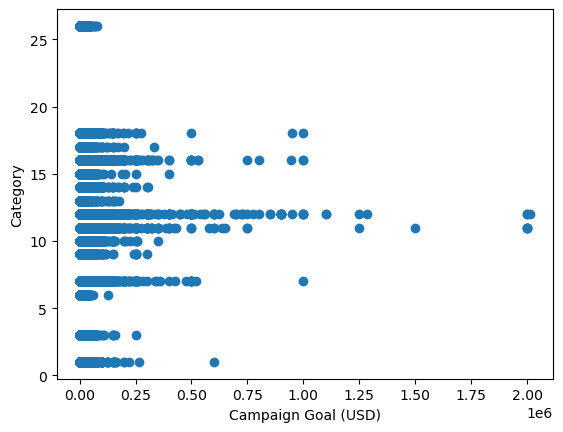

In [15]:
plt.scatter(success_proj["GOAL_IN_USD"], success_proj["CATEGORY"])
plt.xlabel("Campaign Goal (USD)")
plt.ylabel("Category")

We analyze the relationship between categories and project goals for failed projects. 

Text(0, 0.5, 'Category')

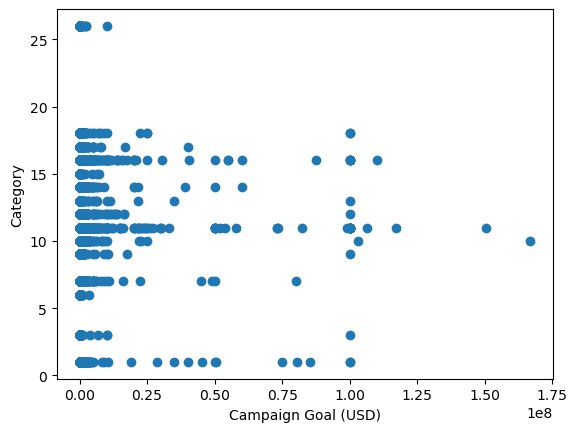

In [17]:
plt.scatter(failed_proj["GOAL_IN_USD"], failed_proj["CATEGORY"])
plt.xlabel("Campaign Goal (USD)")
plt.ylabel("Category")


## Data Description

The attributes (columns) of the dataset are the PID (Project ID), Category (numbers indicating what topic the project falls under), Subcategory (numbers indicating the subtopics within each category), the Project Location Name, State, County, and Country. Other relevant attributes included are the Project Currency, the Project’s Original Goal (how much money the creators were aiming for), amount of money pledged, the number of backers, the launched date, deadline date, and state. State is defined as either suspended (funding for a project is stopped when the project violates Kickstarter’s rules), canceled (the creators of a project dropped the project themselves), failed (the project didn’t meet funding goals), and successful (project meets funding goals). Each observation (row) corresponds to one unique project, indexed with a CaseID.

This dataset was created by Jonathan Leland, Kickstarter’s Head of Insights for a cross-sectional study on the different creative projects that seek crowdfunding. He created the dataset to observe data on the projects from Kickstarter. The creation of this dataset is funded by Kickstarter Data, the company crowdfunding platform that directs the Kickstarter Project. The study is distributed through the Inter-University Consortium for Political and Social Research (ICPSR). 

Some columns may be presented as optional for users to fill out, so we’re left with missing values in the data. For example, for the PROJECT_LOCATION_STATE, PROJECT_LOCATION_COUNTY, PROJECT_LOCATION_COUNTRY column, there are some missing data values. But there are no missing values in the PROJECT_LOCATION_NAME, meaning that the project creators were required to put down the location name for their project. Several restrictions were placed on the data before releasing it for public use. The names of the people/groups who created past Kickstarter projects (NAME) and the links to their projects’ websites (URL_NAME), and the descriptions of their projects (BLURB) are masked in the public data set. This ensures anonymity of survey participants and prevents disclosure risk from survey participants.

This is a link to a google drive folder containing the raw source data: https://drive.google.com/drive/folders/1gySTPJShuvqEASlYBR5odxKNP2Wk9uca?usp=sharing

## Data Limitations

There are several limitations to our research. Since many variables on our public data tsv are restricted, including the project description, we can’t draw a clear relationship between what exactly about a specific category that leads to it being more or less successful than other categories. This affects the meaning of our results because there are unclear causes that may have a greater impact on how successful a project is. Thus, We can only rely on the Category and Subcategory columns, which only shows numbers corresponding to the category type, but not the names of the categories themselves. So, we don't actually have a clear view on the project content. 
There may be outside factors such as branding, social media presence, and popularity of the project before it was put on Kickstarter that may affect the success of the project. These confounding variables can skew our results. 
Furthermore, there are some unclear phrases not explained by the dataset documentation, such as PID and UID. We made the assumption that PID means Project ID, and used it to merge the two datasets. However, if it means something else, then it could negatively affect our data and our conclusions. 


## Questions For Reviewers